In [10]:
import pandas as pd
import numpy as np

# Project introduction

For our machine learning project, we want to try and predict a Airbnb's avaliability for a given month using listing data.

# Data Preperation

In [42]:
# generate two data frames containing all of the listing and calendar data for each location
import os
import pandas as pd

directory_path = 'home_rentals/'

# Initialize an empty list to store DataFrames
listing_df = []
calendar_df = []

# Iterate through subdirectories
for subdirectory in os.listdir(directory_path):
    subdirectory_path = os.path.join(directory_path, subdirectory) 

    csv_listing_file_path = os.path.join(subdirectory_path, "listings.csv.gz")
    csv_calendar_file_path = os.path.join(subdirectory_path, "calendar.csv.gz")
    print(csv_listing_file_path)
    print(csv_calendar_file_path)

    df1 = pd.read_csv(csv_listing_file_path)
    df2 = pd.read_csv(csv_calendar_file_path)

    df1['location'] = subdirectory
    df2['location'] = subdirectory

    listing_df.append(df1)
    calendar_df.append(df2)


# Concatenate all DataFrames into a single DataFrame
all_listing_df = pd.concat(listing_df, ignore_index=True)
all_calendar_df = pd.concat(calendar_df, ignore_index=True)

home_rentals/Zurich/listings.csv.gz
home_rentals/Zurich/calendar.csv.gz
home_rentals/Barcelona/listings.csv.gz
home_rentals/Barcelona/calendar.csv.gz
home_rentals/Milan/listings.csv.gz
home_rentals/Milan/calendar.csv.gz
home_rentals/Valencia/listings.csv.gz
home_rentals/Valencia/calendar.csv.gz
home_rentals/Mallorca/listings.csv.gz
home_rentals/Mallorca/calendar.csv.gz
home_rentals/Washington/listings.csv.gz
home_rentals/Washington/calendar.csv.gz
home_rentals/Rotterdam/listings.csv.gz
home_rentals/Rotterdam/calendar.csv.gz
home_rentals/Tokyo/listings.csv.gz
home_rentals/Tokyo/calendar.csv.gz
home_rentals/Los Angeles/listings.csv.gz
home_rentals/Los Angeles/calendar.csv.gz
home_rentals/Lisbon/listings.csv.gz
home_rentals/Lisbon/calendar.csv.gz
home_rentals/Ireland/listings.csv.gz
home_rentals/Ireland/calendar.csv.gz
home_rentals/Mexico City/listings.csv.gz
home_rentals/Mexico City/calendar.csv.gz
home_rentals/Madrid/listings.csv.gz
home_rentals/Madrid/calendar.csv.gz
home_rentals/Genev

In [43]:
all_calendar_df

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,location
0,73282,2022-09-23,f,$100.00,$100.00,1125.0,1125.0,Zurich
1,73282,2022-09-24,f,$100.00,$100.00,1125.0,1125.0,Zurich
2,73282,2022-09-25,f,$100.00,$100.00,1125.0,1125.0,Zurich
3,73282,2022-09-26,f,$100.00,$100.00,1125.0,1125.0,Zurich
4,73282,2022-09-27,f,$100.00,$100.00,1125.0,1125.0,Zurich
...,...,...,...,...,...,...,...,...
124889345,1825432,2023-09-24,t,$150.00,$140.00,2.0,1125.0,Malaga
124889346,1825432,2023-09-25,t,$150.00,$140.00,2.0,1125.0,Malaga
124889347,1825432,2023-09-26,t,$150.00,$140.00,2.0,1125.0,Malaga
124889348,1825432,2023-09-27,t,$150.00,$140.00,2.0,1125.0,Malaga


In [44]:
all_listing_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

### Removing Irrelevant columns 

Since this dataset has a lot of variables, we can start by removing colums that will be clearly irrelevant for our research question such as the following

- *'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_id', 'host_thumbnail_url', host_url', 'host_name'*  = Identifier variables
-  *'name', 'description', 'neighborhood_overview', 'host_about', 'bathrooms_text'  *  = We will not be working with textual data for this analysis, for the sake of efficiency and time
- *'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude','longitude', region_name', 'region_parent_id', 'region_parent_name','region_parent_parent_id', 'region_parent_parent_name'* = We will only be using Country in our analysis as a geographic identifier, in order to reduce the dimension of our data while keeping some identifiabiltiy (since there are 20 countries)
- *'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365'* = These are variables that will be dependant on our predictor variable in this analysis 

In [45]:
columns_drop = ['scrape_id', 'last_scraped', 'source', 'picture_url', 'host_id', 'host_thumbnail_url', 'host_url','name', 
                    'description', 'neighborhood_overview', 'host_about', 'bathrooms_text', 'neighbourhood',
                      'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude','longitude',
                    'region_name', 'region_parent_id', 'region_parent_name','region_parent_parent_id', 'region_parent_parent_name',
                      'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365']

all_listing_df_1 = all_listing_df.drop(columns=columns_drop) 

### Remove rows that have significant amount of NAN values 
 

In [46]:
all_listing_df_1


,id,listing_url,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_picture_url,...,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,location,last_searched,requires_license,region_id,listings.csv
0,73282.0,https://www.airbnb.com/rooms/73282,Simona,2011-02-04,"Zurich, Switzerland",NaN,NaN,0%,f,https://a0.muscache.com/im/users/377532/profil...,...,1.0,1.0,0.0,0.0,0.39,Zurich,NaN,NaN,NaN,NaN
1,86645.0,https://www.airbnb.com/rooms/86645,James,2011-03-31,NaN,within an hour,100%,98%,t,https://a0.muscache.com/im/users/475053/profil...,...,17.0,17.0,0.0,0.0,0.36,Zurich,NaN,NaN,NaN,NaN
2,143821.0,https://www.airbnb.com/rooms/143821,Erhan,2011-06-13,"Zürich, Switzerland",NaN,NaN,0%,f,https://a0.muscache.com/im/users/697307/profil...,...,1.0,1.0,0.0,0.0,NaN,Zurich,NaN,NaN,NaN,NaN
3,178448.0,https://www.airbnb.com/rooms/178448,Delphine,2011-07-22,"Zurich, Switzerland",within an hour,100%,NaN,f,https://a0.muscache.com/im/users/854016/profil...,...,1.0,0.0,1.0,0.0,0.07,Zurich,NaN,NaN,NaN,NaN
4,204586.0,https://www.airbnb.com/rooms/204586,Aicha,2011-08-22,"Zurich, Switzerland",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1004816/profi...,...,1.0,0.0,1.0,0.0,NaN,Zurich,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342231,50352276.0,https://www.airbnb.com/rooms/50352276,David,2021-06-12,NaN,NaN,NaN,100%,f,https://a0.muscache.com/im/pictures/user/17ef6...,...,1.0,1.0,0.0,0.0,NaN,Malaga,NaN,NaN,NaN,NaN
342232,32705544.0,https://www.airbnb.com/rooms/32705544,Alain,2011-08-05,"Andalusia, Spain",within an hour,100%,100%,t,https://a0.muscache.com/im/users/925118/profil...,...,6.0,6.0,0.0,0.0,2.02,Malaga,NaN,NaN,NaN,NaN
342233,33294303.0,https://www.airbnb.com/rooms/33294303,Sarah,2016-05-16,"Torremolinos, Spain",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/5e388...,...,4.0,4.0,0.0,0.0,0.41,Malaga,NaN,NaN,NaN,NaN
342234,50607554.0,https://www.airbnb.com/rooms/50607554,Paco,2018-04-09,"Chilches, Spain",within a day,100%,100%,f,https://a0.muscache.com/im/pictures/user/0d31d...,...,3.0,3.0,0.0,0.0,0.10,Malaga,NaN,NaN,NaN,NaN


In [56]:
all_listing_df_2 = all_listing_df_1.dropna(thresh=0.50, axis=1)

all_listing_df_2


,id,listing_url,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_picture_url,...,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,location,last_searched,region_id,listings.csv
0,73282.0,https://www.airbnb.com/rooms/73282,Simona,2011-02-04,"Zurich, Switzerland",NaN,NaN,0%,f,https://a0.muscache.com/im/users/377532/profil...,...,f,1.0,1.0,0.0,0.0,0.39,Zurich,NaN,NaN,NaN
1,86645.0,https://www.airbnb.com/rooms/86645,James,2011-03-31,NaN,within an hour,100%,98%,t,https://a0.muscache.com/im/users/475053/profil...,...,t,17.0,17.0,0.0,0.0,0.36,Zurich,NaN,NaN,NaN
2,143821.0,https://www.airbnb.com/rooms/143821,Erhan,2011-06-13,"Zürich, Switzerland",NaN,NaN,0%,f,https://a0.muscache.com/im/users/697307/profil...,...,f,1.0,1.0,0.0,0.0,NaN,Zurich,NaN,NaN,NaN
3,178448.0,https://www.airbnb.com/rooms/178448,Delphine,2011-07-22,"Zurich, Switzerland",within an hour,100%,NaN,f,https://a0.muscache.com/im/users/854016/profil...,...,f,1.0,0.0,1.0,0.0,0.07,Zurich,NaN,NaN,NaN
4,204586.0,https://www.airbnb.com/rooms/204586,Aicha,2011-08-22,"Zurich, Switzerland",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1004816/profi...,...,f,1.0,0.0,1.0,0.0,NaN,Zurich,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342231,50352276.0,https://www.airbnb.com/rooms/50352276,David,2021-06-12,NaN,NaN,NaN,100%,f,https://a0.muscache.com/im/pictures/user/17ef6...,...,t,1.0,1.0,0.0,0.0,NaN,Malaga,NaN,NaN,NaN
342232,32705544.0,https://www.airbnb.com/rooms/32705544,Alain,2011-08-05,"Andalusia, Spain",within an hour,100%,100%,t,https://a0.muscache.com/im/users/925118/profil...,...,t,6.0,6.0,0.0,0.0,2.02,Malaga,NaN,NaN,NaN
342233,33294303.0,https://www.airbnb.com/rooms/33294303,Sarah,2016-05-16,"Torremolinos, Spain",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/5e388...,...,t,4.0,4.0,0.0,0.0,0.41,Malaga,NaN,NaN,NaN
342234,50607554.0,https://www.airbnb.com/rooms/50607554,Paco,2018-04-09,"Chilches, Spain",within a day,100%,100%,f,https://a0.muscache.com/im/pictures/user/0d31d...,...,f,3.0,3.0,0.0,0.0,0.10,Malaga,NaN,NaN,NaN


In [78]:
#INVESTIGATE WHY THIS HASNT BEEN DROPPED
all_listing_df_2['listings.csv'].isna().sum()

321555

In [74]:
#After removing all the columns with more than 50% of NaN values we are now going to look at rows
threshold = 0.70 
all_listing_df_3 = all_listing_df_2.dropna(thresh=float(threshold * len(all_listing_df_2.columns)))
removed_rows = len(all_listing_df_2) - len(all_listing_df_3)
print(f'num of removed rows is {removed_rows}')

all_listing_df_3

num of removed rows is 16328


,id,listing_url,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_picture_url,...,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,location,last_searched,region_id,listings.csv
0,73282.0,https://www.airbnb.com/rooms/73282,Simona,2011-02-04,"Zurich, Switzerland",NaN,NaN,0%,f,https://a0.muscache.com/im/users/377532/profil...,...,f,1.0,1.0,0.0,0.0,0.39,Zurich,NaN,NaN,NaN
1,86645.0,https://www.airbnb.com/rooms/86645,James,2011-03-31,NaN,within an hour,100%,98%,t,https://a0.muscache.com/im/users/475053/profil...,...,t,17.0,17.0,0.0,0.0,0.36,Zurich,NaN,NaN,NaN
3,178448.0,https://www.airbnb.com/rooms/178448,Delphine,2011-07-22,"Zurich, Switzerland",within an hour,100%,NaN,f,https://a0.muscache.com/im/users/854016/profil...,...,f,1.0,0.0,1.0,0.0,0.07,Zurich,NaN,NaN,NaN
5,222565.0,https://www.airbnb.com/rooms/222565,Ysabel,2011-09-14,"Zurich, Switzerland",within an hour,100%,92%,f,https://a0.muscache.com/im/users/1155866/profi...,...,f,1.0,0.0,1.0,0.0,1.71,Zurich,NaN,NaN,NaN
6,227039.0,https://www.airbnb.com/rooms/227039,Lucas,2011-09-20,"Zurich, Switzerland",within a day,100%,40%,f,https://a0.muscache.com/im/pictures/user/23d28...,...,f,1.0,1.0,0.0,0.0,0.23,Zurich,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342230,32328992.0,https://www.airbnb.com/rooms/32328992,Viba Properties,2019-02-12,"Málaga, Spain",NaN,NaN,100%,t,https://a0.muscache.com/im/pictures/user/c271b...,...,t,1.0,1.0,0.0,0.0,0.74,Malaga,NaN,NaN,NaN
342232,32705544.0,https://www.airbnb.com/rooms/32705544,Alain,2011-08-05,"Andalusia, Spain",within an hour,100%,100%,t,https://a0.muscache.com/im/users/925118/profil...,...,t,6.0,6.0,0.0,0.0,2.02,Malaga,NaN,NaN,NaN
342233,33294303.0,https://www.airbnb.com/rooms/33294303,Sarah,2016-05-16,"Torremolinos, Spain",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/5e388...,...,t,4.0,4.0,0.0,0.0,0.41,Malaga,NaN,NaN,NaN
342234,50607554.0,https://www.airbnb.com/rooms/50607554,Paco,2018-04-09,"Chilches, Spain",within a day,100%,100%,f,https://a0.muscache.com/im/pictures/user/0d31d...,...,f,3.0,3.0,0.0,0.0,0.10,Malaga,NaN,NaN,NaN


In [60]:
removed_columns=[col for col in all_listing_df_1 if col not in all_listing_df_2]

print(f'the columns removed are {removed_columns}')

the columns removed are ['bathrooms', 'calendar_updated', 'requires_license']


In [49]:
#this shows that all rows include NANs which is why we are now going to remove all rows with more than 50% of NaN values

threshold = 0.50
all_listing_df_5 = all_listing_df_1.dropna(thresh=int(threshold * len(all_listing_df_1.columns)))

all_listing_df_5


,id,listing_url,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_picture_url,...,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,location,last_searched,requires_license,region_id,listings.csv
0,73282.0,https://www.airbnb.com/rooms/73282,Simona,2011-02-04,"Zurich, Switzerland",NaN,NaN,0%,f,https://a0.muscache.com/im/users/377532/profil...,...,1.0,1.0,0.0,0.0,0.39,Zurich,NaN,NaN,NaN,NaN
1,86645.0,https://www.airbnb.com/rooms/86645,James,2011-03-31,NaN,within an hour,100%,98%,t,https://a0.muscache.com/im/users/475053/profil...,...,17.0,17.0,0.0,0.0,0.36,Zurich,NaN,NaN,NaN,NaN
2,143821.0,https://www.airbnb.com/rooms/143821,Erhan,2011-06-13,"Zürich, Switzerland",NaN,NaN,0%,f,https://a0.muscache.com/im/users/697307/profil...,...,1.0,1.0,0.0,0.0,NaN,Zurich,NaN,NaN,NaN,NaN
3,178448.0,https://www.airbnb.com/rooms/178448,Delphine,2011-07-22,"Zurich, Switzerland",within an hour,100%,NaN,f,https://a0.muscache.com/im/users/854016/profil...,...,1.0,0.0,1.0,0.0,0.07,Zurich,NaN,NaN,NaN,NaN
4,204586.0,https://www.airbnb.com/rooms/204586,Aicha,2011-08-22,"Zurich, Switzerland",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1004816/profi...,...,1.0,0.0,1.0,0.0,NaN,Zurich,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342231,50352276.0,https://www.airbnb.com/rooms/50352276,David,2021-06-12,NaN,NaN,NaN,100%,f,https://a0.muscache.com/im/pictures/user/17ef6...,...,1.0,1.0,0.0,0.0,NaN,Malaga,NaN,NaN,NaN,NaN
342232,32705544.0,https://www.airbnb.com/rooms/32705544,Alain,2011-08-05,"Andalusia, Spain",within an hour,100%,100%,t,https://a0.muscache.com/im/users/925118/profil...,...,6.0,6.0,0.0,0.0,2.02,Malaga,NaN,NaN,NaN,NaN
342233,33294303.0,https://www.airbnb.com/rooms/33294303,Sarah,2016-05-16,"Torremolinos, Spain",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/5e388...,...,4.0,4.0,0.0,0.0,0.41,Malaga,NaN,NaN,NaN,NaN
342234,50607554.0,https://www.airbnb.com/rooms/50607554,Paco,2018-04-09,"Chilches, Spain",within a day,100%,100%,f,https://a0.muscache.com/im/pictures/user/0d31d...,...,3.0,3.0,0.0,0.0,0.10,Malaga,NaN,NaN,NaN,NaN


In [12]:
column_name = 'requires_license'
if all(all_listing_df_1[column_name].isna()):
    print(f"The column {column_name} has only NaN values.")
else:
    print(f"The column {column_name} has some non-NaN values.")


The column requires_license has only NaN values.


In [ ]:
column_name = ''
if all(all_listing_df_1[column_name].isna()):
    print(f"The column {column_name} has only NaN values.")
else:
    print(f"The column {column_name} has some non-NaN values.")


In [10]:
all_listing_df_1 = all_listing_df_1.dropna(axis=0)

all_listing_df_1 

,id,listing_url,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_picture_url,...,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,location,last_searched,requires_license,region_id,listings.csv


### Dealing with the property type

Since there are over 150 unique property types in the dataframe (but we think the type of listing will still be important for avaliability prediction), we want to try and reduce the number of categories for this variable

In [16]:
all_listing_df['property_type'].unique()

array(['Entire rental unit', 'Entire loft', 'Private room in rental unit',
       'Private room in home', 'Entire condo', 'Entire home',
       'Private room in castle', 'Private room in condo',
       'Private room in townhouse', 'Private room in loft',
       'Entire serviced apartment', 'Private room in casa particular',
       'Private room in hut', 'Private room in guesthouse',
       'Private room in villa', 'Tiny home', 'Room in boutique hotel',
       'Private room in bed and breakfast', 'Entire townhouse',
       'Entire guest suite', 'Entire villa', 'Shared room in hostel',
       'Room in hotel', 'Room in serviced apartment',
       'Room in bed and breakfast', 'Shared room in rental unit',
       'Entire guesthouse', 'Private room in guest suite', 'Barn', 'Boat',
       'Private room in serviced apartment',
       'Shared room in bed and breakfast', 'Private room in cabin',
       'Private room', 'Entire vacation home', 'Private room in chalet',
       'Private room in vaca

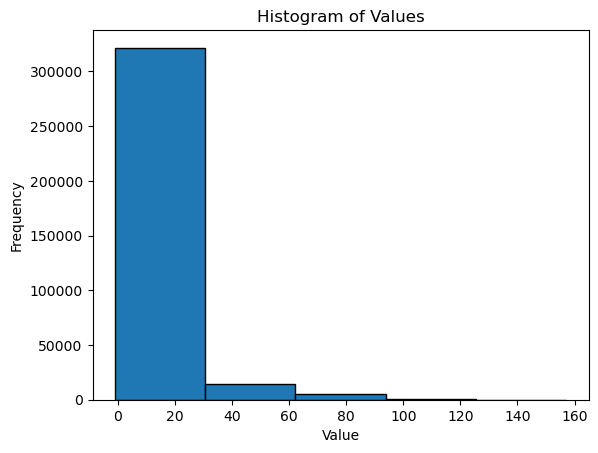

In [17]:
# converting the text to a categorical variable

all_listing_df_1['property_type'] = pd.factorize(all_listing_df_1['property_type'])[0]

#displaying a histogram 

import matplotlib.pyplot as plt

all_listing_df_1['property_type'].plot(kind='hist', bins=5, edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')

# Show the plot
plt.show()

/var/folders/hq/s17lkcqx1rz063zjymbg6mrw0000gn/T/ipykernel_26607/2937832565.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(all_listing_df_1['property_type'], hist=True, kde=True, bins=5, color='blue', hist_kws={'edgecolor': 'black'})


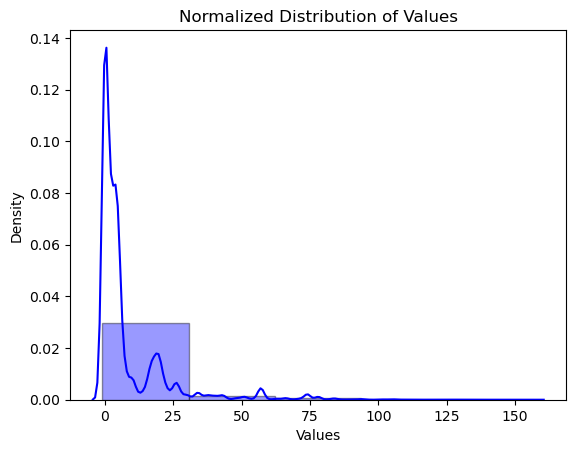

In [18]:
import seaborn as sns

# Plot the normalized distribution using Seaborn
sns.distplot(all_listing_df_1['property_type'], hist=True, kde=True, bins=5, color='blue', hist_kws={'edgecolor': 'black'})

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Normalized Distribution of Values')

# Show the plot
plt.show()

We can see that the distribution is heavily skewed in both the distribution and the histograms, so there are many categories that occur quite rarely. Thus, we can filter to keep the categories that capture 95% of the variation in property type

In [19]:
# Calculate the frequency of each category
category_counts = all_listing_df_1['property_type'].value_counts(normalize=True)

# Filter categories that capture 95% of the variation
threshold = 0.05
selected_categories = category_counts[category_counts >= threshold].index

# Filter the DataFrame based on selected categories
all_listing_df_2 = all_listing_df_1[all_listing_df_1['property_type'].isin(selected_categories)]

all_listing_df_2['property_type'].unique()



array([0, 2, 3, 4, 5])

In [20]:
all_listing_df_2

,id,listing_url,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_picture_url,...,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,location,last_searched,requires_license,region_id,listings.csv
0,73282.0,https://www.airbnb.com/rooms/73282,Simona,2011-02-04,"Zurich, Switzerland",NaN,NaN,0%,f,https://a0.muscache.com/im/users/377532/profil...,...,1.0,1.0,0.0,0.0,0.39,Zurich,NaN,NaN,NaN,NaN
1,86645.0,https://www.airbnb.com/rooms/86645,James,2011-03-31,NaN,within an hour,100%,98%,t,https://a0.muscache.com/im/users/475053/profil...,...,17.0,17.0,0.0,0.0,0.36,Zurich,NaN,NaN,NaN,NaN
3,178448.0,https://www.airbnb.com/rooms/178448,Delphine,2011-07-22,"Zurich, Switzerland",within an hour,100%,NaN,f,https://a0.muscache.com/im/users/854016/profil...,...,1.0,0.0,1.0,0.0,0.07,Zurich,NaN,NaN,NaN,NaN
4,204586.0,https://www.airbnb.com/rooms/204586,Aicha,2011-08-22,"Zurich, Switzerland",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1004816/profi...,...,1.0,0.0,1.0,0.0,NaN,Zurich,NaN,NaN,NaN,NaN
5,222565.0,https://www.airbnb.com/rooms/222565,Ysabel,2011-09-14,"Zurich, Switzerland",within an hour,100%,92%,f,https://a0.muscache.com/im/users/1155866/profi...,...,1.0,0.0,1.0,0.0,1.71,Zurich,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342230,32328992.0,https://www.airbnb.com/rooms/32328992,Viba Properties,2019-02-12,"Málaga, Spain",NaN,NaN,100%,t,https://a0.muscache.com/im/pictures/user/c271b...,...,1.0,1.0,0.0,0.0,0.74,Malaga,NaN,NaN,NaN,NaN
342231,50352276.0,https://www.airbnb.com/rooms/50352276,David,2021-06-12,NaN,NaN,NaN,100%,f,https://a0.muscache.com/im/pictures/user/17ef6...,...,1.0,1.0,0.0,0.0,NaN,Malaga,NaN,NaN,NaN,NaN
342232,32705544.0,https://www.airbnb.com/rooms/32705544,Alain,2011-08-05,"Andalusia, Spain",within an hour,100%,100%,t,https://a0.muscache.com/im/users/925118/profil...,...,6.0,6.0,0.0,0.0,2.02,Malaga,NaN,NaN,NaN,NaN
342233,33294303.0,https://www.airbnb.com/rooms/33294303,Sarah,2016-05-16,"Torremolinos, Spain",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/5e388...,...,4.0,4.0,0.0,0.0,0.41,Malaga,NaN,NaN,NaN,NaN


In [21]:
####################### DO ALL OF THE DATA VERIFICATION STUFF HERE ###############################

'''

Target:  For our machine learning project, we want to try and predict a Airbnb's avaliability for a given month using listing data.


Part 1: 

TO DO FOR DATA CHECKING + VERIFICATION:
- remove columns that have significant amount of NAN calues
- check that there is no property with number of available days > number of days in each  month 
- Check avalibalities (outcome variable) and make sure it is evenly distributed/ resample if needed 


TO DO FOR CONSISTENCY ANALYSIS:
- change dataframe to calculate avalaibilty per month and per location 
- plot average days avaliable for each city
- decide how to allocate consistent vs inconsistent cittes


Part 2:

RUN MODELS: 

Built and Run and test 2 models to try and predict monthly avaliabiltiy 

Model options: NN, linear regression 


'''



#the stuff below is to get the data needed to train the model once the dfs have been cleaned up

"\n\nTarget:  For our machine learning project, we want to try and predict a Airbnb's avaliability for a given month using listing data.\n\n\nPart 1: \n\nTO DO FOR DATA CHECKING + VERIFICATION:\n- remove columns that have significant amount of NAN calues\n- check that there is no property with number of available days > number of days in each  month \n- Check avalibalities (outcome variable) and make sure it is evenly distributed/ resample if needed \n\n\nTO DO FOR CONSISTENCY ANALYSIS:\n- change dataframe to calculate avalaibilty per month and per location \n- plot average days avaliable for each city\n- decide how to allocate consistent vs inconsistent cittes\n\n\nPart 2:\n\nRUN MODELS: \n\nBuilt and Run and test 2 models to try and predict monthly avaliabiltiy \n\nModel options: NN, linear regression \n\n\n"

In [22]:
# Make a new dataframe with the average availability per location, and generate a new data frame with the results

####### THIS CURRENTLY ONLY GENERATES A DATA FRAME WITH AVERAGE AVAILABILITIES PER MONTH BETWEEN ALL PROPERTIES!!! HAVE TO CHANGE THIS
# SUCH THAT IT GENERATES THE AVERAGE AVAILABILITY PER MONTH AND PER LOCATION!!!!! #########
## --> do this once a "location" column has been added to the big calendar data frame 


all_calendar_df["date"] = pd.to_datetime(all_calendar_df["date"])
all_calendar_df["month"] = all_calendar_df["date"].dt.month
all_calendar_df["year"] = all_calendar_df["date"].dt.year
all_calendar_df['month_year'] = all_calendar_df['month'].astype(str) + '-' + all_calendar_df['year'].astype(str)

# make a new data frame
available_by_month = (all_calendar_df[all_calendar_df['available'] == 't'].groupby(['listing_id', 'month_year']).size().unstack(fill_value=0).stack().reset_index(name='days_available'))

# Calculate the average days_available for each month_year (making sure that it rounds to full numbers)
average_by_month = (available_by_month.groupby('month_year')['days_available'].mean().round(0).reset_index(name='average_days_available'))

# convert the month_year column to datetime format 
average_by_month['month_year'] = pd.to_datetime(average_by_month['month_year'], format='%m-%Y').dt.to_period('M')

# sort the rows by ascending dates
average_by_month = average_by_month.sort_values('month_year')

# reset the row index
average_by_month.reset_index(drop=True, inplace=True)

average_by_month


: 

In [ ]:
# check that each location has data for the same months

######## CAN PROBABLY BE DONE MORE EFFICIENTLY ONCE LOCATION HAS BEEN ADDED TO BIG DATA FRAME!!! #########


# all_locations = ["Amsterdam", "Barcelona", "Euskadi", "Geneva", "Ireland", "Lisbon", "Los Angeles", "Madrid", "Malaga", "Mallorca", "Malta", "Menorca", "Mexico City", "Milan", "Naples", 
#                  "Rome", "Rotterdam", "San Diego", "San Francisco", "Tokyo", "Toronto", "Valencia", "Vancouver", "Vienna", "Washington", "Winnipeg", "Zurich"]

all_locations = all_listing_df["location"].unique

for location in all_locations:
    one_loc = average_by_month[average_by_month["location"] == location]
    all_dates = one_loc["month_year"].unique()
    print(location, all_dates)






TypeError: 'method' object is not iterable

As can be seen above, all of the locations have data ranging from 2022-09 to 2023-09, except for Euskadi which has an extra month of data (2023-10). This is an additional month in comparison to the other locations, as such we will remove it to have a consistent range of data between all of the locations. In addition, we can assume that the data for the 2023-10 is incorrect since it predicts there the month has already been fully booked, but when looking at the spread of data for the previous months (almost all of them have at least half of the month unbooked) this seems highly unlikely. 

In [ ]:
# remove the additional month of data for Euskadi

# Create a boolean mask based on the specified conditions
mask = average_by_month['month_year'] == "2023-10"

# Use the boolean mask to filter the DataFrame and keep only the rows that don't match the conditions
average_by_month = average_by_month[~mask]

# check that we got the result we wanted
average_by_month[average_by_month["location"]=="Euskadi"]

,month_year,average_days_available,location
26,2022-09,2.0,Euskadi
27,2022-10,17.0,Euskadi
28,2022-11,20.0,Euskadi
29,2022-12,21.0,Euskadi
30,2023-01,19.0,Euskadi
31,2023-02,18.0,Euskadi
32,2023-03,19.0,Euskadi
33,2023-04,15.0,Euskadi
34,2023-05,16.0,Euskadi
35,2023-06,16.0,Euskadi


We  have now successfully generated a data frame with all of the data required to build our model.

In [ ]:
''' 
TO DO FOR MODEL GENERATION:
- split the data set into test and train  
- etc. 
'''


" \n\nTO DO FOR DATA CHECKING + VERIFICATION:\n- check that there is no data where the number of available days > number of days in the month, and also maybe check if there are any\n    locations with very strange distributions of availabilities over the months??\n- check number of listings per location (shouldn't have any that have too few)\n- go over the property_types and only pick the ones we're interested in (houses, apartments, etc.) and discard everything else  \n    (e.g. windmills, etc.)  --> can also look at how frequently each type appears and only pick the top few types\n\nTO DO FOR MODEL GENERATION:\n- split the data set into test and train  \n- etc. \n"

In [ ]:
import pandas as pd 

amsterdamdata = pd.read_csv('home_rentals\Amsterdam\listings.csv.gz')
amsterdamdata["property_type"].unique()

proptypes = (amsterdamdata.groupby('property_type').count())

proptypes


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
property_type,,,,,,,,,,,,,,,,,,,,,
Barn,4,4,4,4,4,4,4,3,4,4,...,3,3,3,2,4,4,4,4,4,3
Boat,79,79,79,79,79,79,79,52,79,79,...,74,74,74,78,79,79,79,79,79,74
Camper/RV,4,4,4,4,4,4,4,0,4,4,...,2,2,2,3,4,4,4,4,4,2
Cave,1,1,1,1,1,1,1,0,1,1,...,0,0,0,1,1,1,1,1,1,0
Entire bungalow,5,5,5,5,5,5,5,3,5,5,...,4,4,4,2,5,5,5,5,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tent,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,1,1,1,1,1,1
Tiny home,18,18,18,18,18,18,17,14,18,18,...,16,16,16,6,18,18,18,18,18,16
Tower,3,3,3,3,3,3,3,2,3,3,...,3,3,3,3,3,3,3,3,3,3


## Data Anaysis


In [ ]:

city = available_all_loc['location'].unique()

NameError: name 'available_all_loc' is not defined

In [ ]:
file = pd.read_csv("home_rentals/Ireland/reviews.csv.gz")

In [ ]:
file

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,704148680943643330,715761219809350547,2022-09-14,415093097,Guillaume,Louise and her buddy Bohdi are wonderful hosts...
1,606997848080805457,628030426065591294,2022-05-16,427350855,Taynan,Kate Apartament is sparkling clean . She is ea...
2,606997848080805457,631033961631011367,2022-05-20,263380539,Niamh,"Really nice apartment, with everything you nee..."
3,606997848080805457,635363398272267326,2022-05-26,96164395,Jackie,"Great location, spacious apartment and good su..."
4,606997848080805457,637489065335555111,2022-05-29,62628139,Peter,"Good location, easy walking distance to the ma..."
...,...,...,...,...,...,...
1110056,37771431,519750208,2019-08-29,58672654,George,"It was a pleasant stay, due to Robert’s great ..."
1110057,37771431,525773396,2019-09-08,45141196,Esmond,Lovely staying with Robert and family. The roo...
1110058,37771431,530082145,2019-09-15,216358574,Aida,We had a really nice stay with Robert. The roo...
1110059,606130299805738050,691147324135233771,2022-08-11,403300357,Olivier,Appartement superbe et très bien localisé pour...
